# 파이토치 RNN 분류 모델
- 코드 출처: https://tutorials.pytorch.kr/intermediate/char_rnn_classification_tutorial.html

In [1]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip

--2020-10-25 10:13:41--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.32.207.30, 13.32.207.27, 13.32.207.111, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.32.207.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.03s   

2020-10-25 10:13:41 (83.7 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Itali

이름: Ślusàrski

In [4]:
from io import open
import glob
import os

def findFiles(path):
  return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicodeToAscii(s):
  return ''.join(
      c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn' and c in all_letters
  )

print(unicodeToAscii('Ślusàrski'))

category_lines = {}
all_categories = []

def readLines(filename):
  lines = open(filename, encoding='utf-8').read().strip().split('\n')
  return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
  category = os.path.splitext(os.path.basename(filename))[0]
  all_categories.append(category)
  lines = readLines(filename)
  category_lines[category] = lines

n_categories = len(all_categories)

['data/names/French.txt', 'data/names/Italian.txt', 'data/names/Spanish.txt', 'data/names/German.txt', 'data/names/Irish.txt', 'data/names/Dutch.txt', 'data/names/Japanese.txt', 'data/names/Vietnamese.txt', 'data/names/Scottish.txt', 'data/names/Polish.txt', 'data/names/Arabic.txt', 'data/names/English.txt', 'data/names/Korean.txt', 'data/names/Greek.txt', 'data/names/Chinese.txt', 'data/names/Czech.txt', 'data/names/Russian.txt', 'data/names/Portuguese.txt']
Slusarski


In [9]:
print(category_lines['French'][:5])

['Abel', 'Abraham', 'Adam', 'Albert', 'Allard']


In [10]:
import torch

def letterToIndex(letter):
  return all_letters.find(letter)

def letterToTensor(letter):
  tensor = torch.zeros(1, n_letters)
  tensor[0][letterToIndex(letter)] = 1
  return tensor

def lineToTensor(line):
  tensor = torch.zeros(len(line), 1, n_letters)
  for li, letter in enumerate(line):
    tensor[li][0][letterToIndex(letter)] = 1
  return tensor

print(letterToTensor('J'))
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


## 신경망 생성

- 모델 생성 방법 참고 : https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html

In [14]:
import torch.nn as nn

class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNN, self).__init__()

    self.hidden_size = hidden_size
    self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
    self.i2o = nn.Linear(input_size + hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, input, hidden):
    combine = torch.cat((input, hidden), 1)
    hidden = self.i2h(combine)
    output = self.i2o(combine)
    output = self.softmax(output)
    return output, hidden

  def initHidden(self):
    return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [16]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)
print(output)

tensor([[-2.9378, -2.9134, -2.8992, -2.9256, -2.8546, -2.9452, -2.8308, -2.8676,
         -2.8577, -2.8289, -2.8135, -3.0253, -2.9375, -2.8832, -2.8548, -2.8728,
         -2.8838, -2.9177]], grad_fn=<LogSoftmaxBackward>)


In [18]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9378, -2.9134, -2.8992, -2.9256, -2.8546, -2.9452, -2.8308, -2.8676,
         -2.8577, -2.8289, -2.8135, -3.0253, -2.9375, -2.8832, -2.8548, -2.8728,
         -2.8838, -2.9177]], grad_fn=<LogSoftmaxBackward>)


## 모델 학습
- 준비

In [19]:
def categoryFromOutput(output):
  top_n, top_i = output.topk(1)
  category_i = top_i[0].item()
  return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Arabic', 10)


In [23]:
import random

def randomChoice(l):
  return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
  category = randomChoice(all_categories)
  line = randomChoice(category_lines[category])
  category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
  line_tensor = lineToTensor(line)
  return category, line, category_tensor, line_tensor

for i in range(10):
  category, line, category_tensor, line_tensor = randomTrainingExample()
  print('category: {} \t line: {}'.format(category, line))

category: French 	 line: Babineaux
category: Arabic 	 line: Issa
category: Japanese 	 line: Hayami
category: Polish 	 line: Bosko
category: Korean 	 line: Kim
category: English 	 line: Doble
category: German 	 line: Siemon
category: French 	 line: Lyon
category: German 	 line: Voss
category: Chinese 	 line: Ming


## 손실함수

In [24]:
criterion = nn.NLLLoss()

## 모델 학습

In [25]:
learning_rate = 0.005

def train(category_tensor, line_tensor):
  hidden = rnn.initHidden()

  rnn.zero_grad()

  for i in range(line_tensor.size()[0]):
    output, hidden = rnn(line_tensor[i], hidden)

  loss = criterion(output, category_tensor)
  loss.backward()

  for p in rnn.parameters():
    p.data.add_(p.grad.data, alpha=-learning_rate)

  return output, loss.item()

In [28]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

def timeSince(since):
  now = time.time()
  s = now - since
  m = math.floor(s / 60)
  s -= m * 60
  return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters+1):
  category, line, category_tensor, line_tensor = randomTrainingExample()
  output, loss = train(category_tensor, line_tensor)
  current_loss += loss

  if iter % print_every == 0:
    guess, guess_i = categoryFromOutput(output)
    correct = 'O' if guess == category else 'X (%s)' % category
    print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter/n_iters * 100, timeSince(start), loss, line, guess, correct))

  if iter % plot_every == 0:
    all_losses.append(current_loss / plot_every)
    current_loss = 0

5000 5% (0m 5s) 2.4103 Dobulevich / Irish X (Russian)
10000 10% (0m 11s) 1.3597 Chu / Chinese X (Korean)
15000 15% (0m 17s) 1.7204 Jacques / Portuguese X (French)
20000 20% (0m 23s) 2.2740 Macdonald / Irish X (Scottish)
25000 25% (0m 29s) 1.7956 Rodagh / Arabic X (Irish)
30000 30% (0m 35s) 0.6732 Hakhaev / Russian O
35000 35% (0m 40s) 0.0249 Zdunowski / Polish O
40000 40% (0m 46s) 0.5114 Veen / Dutch O
45000 45% (0m 52s) 0.9017 Dalach / Irish O
50000 50% (0m 58s) 1.0563 Bellerose / French O
55000 55% (1m 4s) 0.4623 Ramsay / Scottish O
60000 60% (1m 9s) 0.5691 Zang / Chinese O
65000 65% (1m 15s) 0.4901 Reinders / Dutch O
70000 70% (1m 21s) 1.3729 Zipperer / German X (Czech)
75000 75% (1m 26s) 2.7160 Krantz / German X (Dutch)
80000 80% (1m 32s) 0.4807 Niadh / Irish O
85000 85% (1m 38s) 4.3991 Oxenham / Irish X (English)
90000 90% (1m 43s) 0.0986 Kreskas / Greek O
95000 95% (1m 49s) 2.9800 Salazar / Portuguese X (Spanish)
100000 100% (1m 55s) 2.2253 Beckert / Dutch X (German)


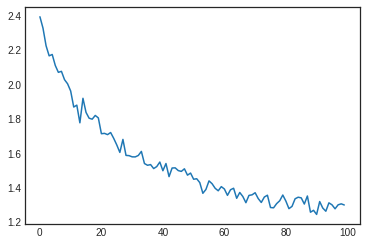

In [29]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-white')

plt.figure()
plt.plot(all_losses)
plt.show()

## 모델 테스트

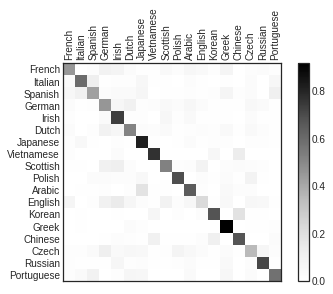

In [30]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

def evaluate(line_tensor):
  hidden = rnn.initHidden()

  for i in range(line_tensor.size()[0]):
    output, hidden = rnn(line_tensor[i], hidden)

  return output

for i in range(n_confusion):
  category, line, category_tensor, line_tensor = randomTrainingExample()
  output = evaluate(line_tensor)
  guess, guess_i = categoryFromOutput(output)
  category_i = all_categories.index(category)
  confusion[category_i][guess_i] += 1

for i in range(n_categories):
  confusion[i] = confusion[i] / confusion[i].sum()

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

## 사용자 입력으로부터의 실행

In [34]:
def predict(input_line, n_predictions=3):
  print('\n> %s' % input_line)
  with torch.no_grad():
    output = evaluate(lineToTensor(input_line))

    topv, topi = output.topk(n_predictions, 1, True)
    predictions = []

    for i in range(n_predictions):
      value = topv[0][i].item()
      category_index = topi[0][i].item()
      print('(%.2f) %s' % (value, all_categories[category_index]))
      predictions.append([value, all_categories[category_index]])

predict('Jackson')
predict('Bill')
predict('Son')
predict('Dovesky')
predict('Lee')
predict('Park')


> Jackson
(-1.13) Scottish
(-1.35) Russian
(-1.59) English

> Bill
(-1.52) Irish
(-1.59) English
(-1.97) Czech

> Son
(-0.20) Korean
(-2.28) Chinese
(-3.77) Vietnamese

> Dovesky
(-0.82) Czech
(-0.86) Russian
(-2.70) Polish

> Lee
(-1.04) Chinese
(-1.62) Vietnamese
(-2.12) Korean

> Park
(-1.39) Dutch
(-1.44) Polish
(-1.93) Czech
